# Text data

In [1]:
import numpy as np
from sklearn.datasets import load_files
from sklearn.feature_extraction.text import CountVectorizer,TfidfTransformer
from sklearn.naive_bayes import MultinomialNB
from sklearn.metrics import (confusion_matrix,precision_score,recall_score,f1_score,
    roc_curve,roc_auc_score,precision_recall_curve,accuracy_score,classification_report)
from sklearn.decomposition import LatentDirichletAllocation,PCA
from sklearn.neural_network import MLPClassifier
import matplotlib.pyplot as plt
import time

## Part 1: preprocessing and vectorization

We use a dataset containing movie reviews from the *Internet Movie Database*. For this, the data first needs to be downloaded from <a href="http://ai.stanford.edu/~amaas/data/sentiment/"> here </a>. Note: this is about 220 Mb.  After uncompressing, the data is contained in a directory `aclImdb` with sub-directories `train` and `test`. In the following, replace the piece of the path that leads to the directory in which you have unpacked the data:

In [5]:
reviews_train=load_files('/Users/hecter/Downloads/aclImdb/train/',categories=['neg','pos'])
reviews_test = load_files('/Users/hecter/Downloads/aclImdb/test/',categories=['neg','pos'])

In [7]:
print(reviews_train.target_names)
revidx = 2
print(reviews_train.data[revidx])
print(reviews_train.target[revidx])

['neg', 'pos']
b'Everyone plays their part pretty well in this "little nice movie". Belushi gets the chance to live part of his life differently, but ends up realizing that what he had was going to be just as good or maybe even better. The movie shows us that we ought to take advantage of the opportunities we have, not the ones we do not or cannot have. If U can get this movie on video for around $10, it\xc2\xb4d be an investment!'
1


First, we create a dictionary (using training data only!):

In [8]:
dictionary=CountVectorizer(min_df=0.0005, max_df=0.5).fit(reviews_train.data)

In [9]:
print("The dictionary contains {} entries".format(len(dictionary.vocabulary_)))
wrd='charming'

print("The index of the word '{}' in the dictionary is {}".format(wrd,dictionary.vocabulary_[wrd]))
widx=708
print("The word at index {} is '{}'".format(widx,dictionary.get_feature_names_out()[widx]))

The dictionary contains 15862 entries
The index of the word 'charming' in the dictionary is 2466
The word at index 708 is 'an'


We can check the underlying preprocessing:

In [10]:
analyze = dictionary.build_analyzer()
print(analyze(reviews_train.data[revidx]))

['everyone', 'plays', 'their', 'part', 'pretty', 'well', 'in', 'this', 'little', 'nice', 'movie', 'belushi', 'gets', 'the', 'chance', 'to', 'live', 'part', 'of', 'his', 'life', 'differently', 'but', 'ends', 'up', 'realizing', 'that', 'what', 'he', 'had', 'was', 'going', 'to', 'be', 'just', 'as', 'good', 'or', 'maybe', 'even', 'better', 'the', 'movie', 'shows', 'us', 'that', 'we', 'ought', 'to', 'take', 'advantage', 'of', 'the', 'opportunities', 'we', 'have', 'not', 'the', 'ones', 'we', 'do', 'not', 'or', 'cannot', 'have', 'if', 'can', 'get', 'this', 'movie', 'on', 'video', 'for', 'around', '10', 'it', 'be', 'an', 'investment']


The dictionary construction with `CountVectorizer` does not include stemming:

In [11]:
print(dictionary.get_feature_names_out()[6951:6956])

['horrendous' 'horrendously' 'horrible' 'horribly' 'horrid']


More specialized tools for tokenization, stemming etc. are provided by the 'nltk' package. We leave this out for now, and go ahead with transforming the data into tf feature vectors:

In [12]:
reviews_train_tf=dictionary.transform(reviews_train.data)

print("The type of 'reviews_train_tf' is {} with {} rows \
and {} columns".format(type(reviews_train_tf),reviews_train_tf.shape[0],reviews_train_tf.shape[1]))

The type of 'reviews_train_tf' is <class 'scipy.sparse._csr.csr_matrix'> with 25000 rows and 15862 columns


The sparse matrix structure becomes visible, when we print the first 1000 entries of the row for the review at index `revidx`:

In [13]:
print(reviews_train_tf[revidx,0:1000])

  (0, 7)	1
  (0, 446)	1
  (0, 708)	1
  (0, 951)	1


The missing 0s are still 'there':

In [14]:
print(reviews_train_tf[revidx,405])

0


We also construct a tf-idf representation of the reviews:

In [15]:
tfidf_transformer_train=TfidfTransformer().fit(reviews_train_tf)
reviews_train_tfidf=tfidf_transformer_train.transform(reviews_train_tf)
print(reviews_train_tfidf[revidx,0:1000])

  (0, 951)	0.11428633904228334
  (0, 708)	0.0627784554562377
  (0, 446)	0.22416564513504342
  (0, 7)	0.10966712876468465


### Using the feature vector for prediction

Learning a Naive Bayes model:

In [16]:
mnb=MultinomialNB().fit(reviews_train_tf,reviews_train.target)

Loading and transforming the test data. The dictionary used for the test data is the one constructed from the training data! Also the transformation with the idf values is done using the TfidfTransformer constructed from the training data.

In [17]:
reviews_test_tf=dictionary.transform(reviews_test.data)
reviews_test_tfidf = tfidf_transformer_train.transform(reviews_test_tf)

Applying the learned model to the test data:

In [18]:
predictions_train=mnb.predict(reviews_train_tf)
predictions_test=mnb.predict(reviews_test_tf)

print("Accuracy on test: \n {}\n".format(accuracy_score(reviews_test.target,predictions_test)))
print("Accuracy on train: \n {}\n".format(accuracy_score(reviews_train.target,predictions_train)))

Accuracy on test: 
 0.82968

Accuracy on train: 
 0.87324



We can find out about what words are most indicative of postive/negative reviews, by looking at the parameters of the model.

The attribute `feature_log_prob_` returns the log probabilities of the different features (words) under the two classes. By taking the difference for the two classes, we get a measure for how much a word discriminates between the two classes:

In [19]:
log_prob_diff=mnb.feature_log_prob_[0,:]-mnb.feature_log_prob_[1,:]

We can use `np.argsort` to obtain the indices of the values in log_prob_diff in increasing order:

In [20]:
sorted_idxs=np.argsort(log_prob_diff)
print(sorted_idxs[0:30])

[ 4636   814  4116  6443  6210 15802 10285 15226  1626  6127  1851  3723
  6576 10163  9993 14676 12154  1200  8898  3610  1609  7923 14593  6806
  9862 12647  8048 10302  6439 15122]


... and retrieve the words corresponding to these indices:

In [21]:
numfeats=20
print("The {} words most discriminating for positive reviews are:\n".format(numfeats))
for i in sorted_idxs[0:numfeats]:
    print(dictionary.get_feature_names_out()[i])
print("\n")    
print("The {} words most discriminating for negative reviews are:\n".format(numfeats))
for i in sorted_idxs[len(sorted_idxs)-numfeats:len(sorted_idxs)]:
    print(dictionary.get_feature_names_out()[i])    

The 20 words most discriminating for positive reviews are:

edie
antwone
din
gunga
goldsworthy
yokai
paulie
visconti
blandings
gino
brashear
deathtrap
harilal
panahi
ossessione
tsui
sabu
aweigh
mcintire
daisies


The 20 words most discriminating for negative reviews are:

weisz
wayans
dyer
rosanna
dahmer
dunaway
savini
beowulf
seagal
thunderbirds
manos
shaq
btk
saif
kareena
hobgoblins
tashan
slater
uwe
boll


This indicates that we are overfitting due to very rare words. We can inspect instead words that are a little bit away from the extreme ends of the sorted log_prob_diff vector: 

In [22]:
numfeats=20
offset = 500
print("Words with 'positive rank' between {} and {}:\n".format(offset,offset+numfeats))
for i in sorted_idxs[offset:offset+numfeats]:
    print(dictionary.get_feature_names_out()[i])
print("\n")    
print("Words with 'positive rank' between {} and {}:\n".format(len(sorted_idxs)-numfeats-offset,len(sorted_idxs)-offset))
for i in sorted_idxs[len(sorted_idxs)-numfeats-offset:len(sorted_idxs)-offset]:
    print(dictionary.get_feature_names_out()[i])    

Words with 'positive rank' between 500 and 520:

alienate
opposites
undercurrent
companionship
moriarty
swordplay
demme
conductor
amicus
sergeants
trading
seamlessly
cheryl
corinne
brilliantly
iran
shanghai
mesmerizing
favorites
sullivan


Words with 'positive rank' between 15342 and 15362:

whack
humourless
sasquatch
winston
aimlessly
whopping
plastic
horribly
horrendous
rambo
lackluster
hulk
rehash
dafoe
bother
simpson
rubber
cringing
costs
dumb


We try a neural network classifier on the tf-idf transformed data next. We use a fairly strong regularization with `alpha=0.5` to compensate for the strong overfitting opportunities in this dataset.

In [23]:
from sklearn.neural_network import MLPClassifier
mlp = MLPClassifier(alpha=0.5).fit(reviews_train_tfidf, reviews_train.target)

/Users/hecter/miniconda3/lib/python3.11/site-packages/sklearn/neural_network/_multilayer_perceptron.py:693: UserWarning: Training interrupted by user.
  warnings.warn("Training interrupted by user.")


While this is runnig (~ 5 minutes ...?), we can take a little break!

In [ ]:
predictions_train=mlp.predict(reviews_train_tfidf)
predictions_test=mlp.predict(reviews_test_tfidf)


print("Accuracy on test: \n {}\n".format(accuracy_score(reviews_test.target,predictions_test)))
print("Accuracy on train: \n {}\n".format(accuracy_score(reviews_train.target,predictions_train)))

We find the reviews that are evaluated as most positive (negative) by the MLP:

In [ ]:
most_positive=np.argsort( mlp.predict_proba(reviews_test_tfidf)[:,0] )
print(most_positive)

In [ ]:
numrevs = 3

print("The {} reviews ranked as most positive are:\n".format(numrevs))
for i in most_positive[0:numrevs]:
    print(reviews_test.data[i])
    print("\n\n")
 
print("The {} reviews ranked as most negative are:\n".format(numrevs))
for i in most_positive[len(most_positive)-numrevs:len(most_positive)]:
    print(reviews_test.data[i])
    print("\n\n")
 

# Opgaver

**Exercise**: install the 'nltk' package https://www.nltk.org/. Now 

In [28]:
import nltk
from nltk.tokenize import word_tokenize
nltk.download('punkt') #Provides tokenization rules for English
from nltk.stem.porter import PorterStemmer

[nltk_data] Downloading package punkt to /Users/hecter/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.


should work. The package provides customizable methods for tokenization and stemming:

In [73]:
revidx = 2

#print("Tokenized: \n {}".format(tokens))
ps=PorterStemmer()
def stem(review):
    tokens=word_tokenize(str(review))
    stemmed = []
    for t in tokens:
        stemmed.append(ps.stem(t))
    
    stemmed = " ".join(stemmed)
    
    return stemmed

stemmed = stem(reviews_train.data[revidx]) 

print("Stemmed: \n {}".format(stemmed))

Stemmed: 
 b'everyon play their part pretti well in thi `` littl nice movi '' . belushi get the chanc to live part of hi life differ , but end up realiz that what he had wa go to be just as good or mayb even better . the movi show us that we ought to take advantag of the opportun we have , not the one we do not or can not have . if u can get thi movi on video for around $ 10 , it\xc2\xb4d be an invest ! '


In [71]:
reviews_train.data[revidx]

b'Everyone plays their part pretty well in this "little nice movie". Belushi gets the chance to live part of his life differently, but ends up realizing that what he had was going to be just as good or maybe even better. The movie shows us that we ought to take advantage of the opportunities we have, not the ones we do not or cannot have. If U can get this movie on video for around $10, it\xc2\xb4d be an investment!'

**Exercise continued**: Create a new (smaller) dictionary from stemmed versions of the reviews. How has the size of the dictionary changed, when you use the same min_df, max_df parameters in the CountVectorizer as before? Redo the NaiveBayes and MLP training with the modified data. Does accuracy improve?

In [65]:
stemmed_corpus = []
for i in range(len(reviews_train.data)):
    stemmed_corpus.append(stem(reviews_train.data[i]))

In [66]:
dictionary=CountVectorizer(min_df=0.0005, max_df=0.5).fit(stemmed_corpus)

In [68]:
sorted(dictionary.vocabulary_.items(), key=lambda x: x[1], reverse=False)[0:10]

[('00', 0),
 ('000', 1),
 ('007', 2),
 ('01', 3),
 ('02', 4),
 ('05', 5),
 ('06', 6),
 ('10', 7),
 ('100', 8),
 ('1000', 9)]

In [69]:
print("The dictionary contains {} entries".format(len(dictionary.vocabulary_)))
wrd='your'

print("The index of the word '{}' in the dictionary is {}".format(wrd,dictionary.vocabulary_[wrd]))
widx=5
print("The word at index {} is '{}'".format(widx,dictionary.get_feature_names_out()[widx]))

The dictionary contains 11878 entries
The index of the word 'your' in the dictionary is 11828
The word at index 5 is '05'


In [74]:
reviews_test_tf=dictionary.transform(reviews_test.data)
reviews_test_tfidf = tfidf_transformer_train.transform(reviews_test_tf)

ValueError: X has 11878 features, but TfidfTransformer is expecting 15862 features as input.

### Part 2: word vectors

We import a pre-computed 100-dimensional embedding of a vocabulary of 400.000 words. The data can be imported from <a href="http://nlp.stanford.edu/data/glove.6B.zip">here</a> from the <a href="https://nlp.stanford.edu/projects/glove/">Glove homepage</a>

In [57]:
# This piece of code copied from https://stackoverflow.com/questions/37793118/load-pretrained-glove-vectors-in-python

def loadGloveModel(File):
    print("Loading Glove Model")
    f = open(File,'r')
    gloveModel = {}
    for line in f:
        splitLines = line.split()
        word = splitLines[0]
        wordEmbedding = np.array([float(value) for value in splitLines[1:]])
        gloveModel[word] = wordEmbedding
    print(len(gloveModel)," words loaded!")
    return gloveModel

gl=loadGloveModel('/Users/hecter/Downloads/glove.6B/glove.6B.100d.txt')

print("The type of the loaded model is {} \n ".format(type(gl)))
print("The embedding vector of 'university' is \n {}".format(gl['university']))

Loading Glove Model
400000  words loaded!
The type of the loaded model is <class 'dict'> 
 
The embedding vector of 'university' is 
 [ 0.6958    -0.19334   -0.78134   -0.45589    0.29245    0.36482
  0.42036    0.39444   -0.82601    0.95148   -0.57458   -0.60882
  0.17639    1.2112    -0.40965   -0.30992    1.036      0.14459
 -0.66125   -0.15301   -0.60274    0.43769    0.09964    0.084613
 -0.13351   -0.66612    0.30282   -1.2281     0.20226   -0.025091
 -1.0822     1.2366     0.027486   0.49969   -1.3037    -0.52735
 -0.72448    0.64823   -1.0533    -0.051606  -1.1125    -0.21037
 -0.86862   -0.55893   -0.12559   -0.16766    1.2164     0.68335
  0.0060452  0.28108    0.42866   -1.0092     0.40758   -0.19904
 -0.5442    -2.7965    -0.11892   -0.98139    1.0011     0.13492
 -0.16678    0.4366    -0.022247  -0.30683    0.26983    0.18009
 -0.12419    1.1771     0.90273    1.6263    -0.20432    0.33125
  0.2568    -0.23611   -0.81554    0.043468   0.73481   -0.013573
 -0.61923   -0.123

Coming back to our movie reviews, we create another dictionary from the reviews in the training set. We now set limits that terms included in the dictionary should appear in at least 5% and at most 80% of reviews. These are rather narrow bounds, which are set under the assumption that typical words expressing sentiments will fall into these bounds, while stop words and very many more specific words will be excluded. As it turns out, we create a rather small vocabulary in this manner.

In [58]:
dictionary_small=CountVectorizer(min_df=0.05, max_df=0.8).fit(reviews_train.data)

ld=len(dictionary_small.vocabulary_)
print("Created a dictionary with {} tokens: \n".format(ld)) 
for i in range(ld):
    print(dictionary_small.get_feature_names()[i])

Created a dictionary with 420 tokens: 



AttributeError: 'CountVectorizer' object has no attribute 'get_feature_names'

Creating new tf feature vectors for the smaller dictionary:

In [ ]:
reviews_train_tf=dictionary_small.transform(reviews_train.data)
reviews_test_tf=dictionary_small.transform(reviews_test.data)

We only need the Glove vector representations of the words in our dictionary. We therefore extract from our 400.000 word original Glove dictionary the relevant ones, and collect them in a matrix:


In [ ]:
dict_glove=np.zeros((ld,100))
for i in range(ld):
    dict_glove[i,:]=gl[dictionary_small.get_feature_names()[i]]

We now represent each review by the average of the Glove word vectors of the words in the review (only taking into account those that are in our dictionary) 

In [ ]:
reviews_train_glove= np.matmul(reviews_train_tf.todense(),dict_glove)
for r in range(25000):
    reviews_train_glove[r,:]*=(1/np.sum(reviews_train_tf[r,:]))

reviews_test_glove= np.matmul(reviews_test_tf.todense(),dict_glove)
for r in range(25000):
    reviews_test_glove[r,:]*=(1/np.sum(reviews_test_tf[r,:]))    
    
print("glove feature matrix for training reviews has dimensions {}".format(reviews_train_glove.shape))
print("glove feature matrix for testing reviews has dimensions {}".format(reviews_test_glove.shape))    

We now train classifiers for predicting the sentiment of a review from either the term-frequency features, or the GLove average embedding vectors. Remember that the tf-vectors are now over a smaller dictionary, so the accuracy results we get can be expected to be lower than in Part 1. The true class labels are retrieved by `reviews_train.target` and `reviews_test.target`

In [ ]:
classifyer = MLPClassifier((10))
#classifyer =  LogisticRegression(solver='lbfgs')
train={}
train["tf"]=reviews_train_tf
train["glove"]=reviews_train_glove
test={}
test["tf"]=reviews_test_tf
test["glove"]=reviews_test_glove

for features in ("tf","glove"):
    print("Training with " + features + "  features \n")
    classifyer.fit(train[features],reviews_train.target)
    pred_train=classifyer.predict(train[features])
    pred_test=classifyer.predict(test[features])
    print("Evaluation on training data: \n")
    print("Confusion matrix: \n {}".format(confusion_matrix(pred_train,reviews_train.target)))
    print("Accuracy: \n {} \n".format(accuracy_score(pred_train,reviews_train.target)))
    print("Evaluation on test data: \n")
    print("Confusion matrix: \n {}".format(confusion_matrix(pred_test,reviews_test.target)))
    print("Accuracy: \n {}\n\n".format(accuracy_score(pred_test,reviews_test.target)))
    

Dependent on the random initializations, some learning runs here may end with an warning message that the optimization has not converged after the maximum number of iterations. In that case one can re-run, increase the maximum number of iterations, or live with the results that one has obtained from the not fully converged runs...

In these initial experiments, we are likely to see results where the Glove features lead to a slightly lower accuracy on the test data than the TF features. One could explore this further in many different dimensions: modify the underlying vocabulary, create more sophisticated Glove-based features than simple averages, consider other classification models, ...

Finally, we can visualize the Glove embeddings of the words in our dictionary by plotting a 2-dimensional projection computed by principal component analysis (PCA): 

In [ ]:
pca=PCA(n_components=2)
glove_pca=pca.fit_transform(dict_glove)

In [ ]:
plt.figure(figsize=(30,30))
plt.scatter(glove_pca[:,0],glove_pca[:,1],)

for i in range(ld):
    plt.annotate(dictionary_small.get_feature_names()[i],(glove_pca[i,0],glove_pca[i,1]),fontsize=20)
plt.show()

This picture can partly explain why our sentiment analysis task remains hard with Glove features:  relevant descriptive adjectives 'stupid', 'awful', 'wonderful', 'funny', 'boring', ... are clustered in the same area of the latent space. It would be more helpful, if the positive adjectives were well separated from the negative adjectives (bearing in mind, that this 2-d projection does not tell the whole story!). 

An interesting detail can be seen on the top of the plot: from this embedding, we would obtain for the analogical query <i>'films' is to 'film' what ??? is to 'movie'</i> the answer ???='movies'.

### Part 3: LDA

Since LDA requires some rather time-consuming computations, we again create a dictionary with a suitable size ...

In [ ]:
dictionary=CountVectorizer(min_df=0.01, max_df=0.15).fit(reviews_train.data)
print("The dictionary contains {} entries".format(len(dictionary.vocabulary_)))
reviews_train_tf=dictionary.transform(reviews_train.data)
reviews_train_tfidf=TfidfTransformer().fit_transform(reviews_train_tf)

We now fit an LDA model with `ntopics` latent topics. The LDA learner has a parameter `max_iter` that determines how many iterations over the whole dataset are performed. A *perplexity* score measures how well the learned model explains/fits the data. When time permits, one can see how the perplexity score improves when one allows more iterations in the learning process.

In [ ]:
ntopics=20

#maxiters = np.array([5,10])
maxiters = 5

for m in range(maxiters):
    start=time.time()
    lda = LatentDirichletAllocation(n_components=ntopics,learning_method='online',max_iter=m).fit(reviews_train_tf)
    end=time.time()
    print("Time: {}s".format(end-start))
    print("Iterations performed: {}".format(lda.n_iter_))
    print("Perplexity score: {}".format(lda.perplexity(reviews_train_vec)))

In [ ]:
lda.get_params()

The attribute `components_` contains the word probabilities for the latent topics (not strictly probabilities, because they do not sum to 1 over all words):

In [ ]:
print(lda.components_.shape)
comp=0
f=30
print("The first {} words have the following 'probabilities' in component {}:\n {}\n"\
      .format(f,comp,lda.components_[comp,0:f]))

We next investigate which words have the highest probabilities under the different topics:

In [ ]:
widx_ranks=np.argsort(lda.components_,axis=1)

numwords=20
for i in np.arange(ntopics):
    print("Topic {}\n".format(i))
    for j in np.arange(numwords):
        print(dictionary.get_feature_names()[widx_ranks[i,len(dictionary.vocabulary_)-j-1]])
    print("\n")

Next, we investigate the topic distributions assigned to the different reviews. These have first to be computed using the `transform` method:

In [ ]:
topicvecs = lda.transform(reviews_train_tf)

print(topicvecs.shape)
print(topicvecs[0:3,:])

Finally, we can look which reviews are most strongly connected to any specific topic

In [ ]:

toprevs_by_topic=np.argsort(topicvecs,axis=0)

In [ ]:
# The index of the topic we want to investigate
topicno=7
# The number of reviews most highly associated with the topic that we want to see
norevs=4

l=len(toprevs_by_topic)-1

for i in np.arange(norevs):    
    print(reviews_train.data[toprevs_by_topic[l-i,topicno]])

    print("\n")

**Exercise:** Try different classifiers (MLP, SVM) for classifying the reviews based on their topic vectors. <b>

# Exercise (self study) 
Fix a dimensionality d for vector representations, e.g. d=50, d=100, d=1000. Construct different representations of the reviews as d-dimensional vectors: <b>
    
<ul>
    <li>tf-idf vectors for a dictionary of size d</li>
     <li>mean word embedding vectors from d-dimensional word vectors (the GloVe homepage provides embeddings of different dimensions)</li>
    <li>LDA topic vectors for d topics </li>
 </ul>
    
Train and evaluate different classifiers on these different representations. What are the relevant tuning possibilities you can use to optimize the performance of each type of representation? Which approach gives you the best performance for the given "budget" of d dimensions for representation?

In [24]:
reviews_train = load_files('/Users/hecter/Downloads/aclImdb/train/',categories=['neg','pos'])
reviews_test = load_files('/Users/hecter/Downloads/aclImdb/test/',categories=['neg','pos'])

### TF-IDF vectors
* $TF(d)$: D-dimensional integer-vector with $TF(d)[i]$ = number of occurrences of the $i$’th dictionary term in $d$.
* IDF: For $i$'th word in dictionary relative to corpus $c$: $idf(i,c)=\text{log } \dfrac{N}{N_i}$ ;$N$ is number of documents in corpus and $N_i$ is number of documents in corpus containing $i$.
* TF-IDF: Multiply tf-values with idf scores:
$$
tfidf(d)[i] = tf(d)[i]idf(i,c)
$$

1. Calculate TF-IDF scores for all words in the corpus and sort them in descending order based on TF-IDF score.
2. Choose either the top 50, 100 or 1000 words and create the TF-IDF vector for each document.

In [48]:
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import LogisticRegression

for max_features in (10,50,1000):
    vectorizer = TfidfVectorizer(max_features=max_features)
    tfidf_vectors = vectorizer.fit_transform(reviews_train.data)
    tfidf_vectors_test = vectorizer.transform(reviews_test.data)

    # Train and evaluate naive bayes classifier
    nb_model = MultinomialNB().fit(tfidf_vectors, reviews_train.target)
    predictions = nb_model.predict(tfidf_vectors_test)
    print(f"Naive bayes accuracy - num features {max_features}:", accuracy_score(reviews_test.target, predictions))
    
    # Train and evaluate logistic regression model
    lr_model = LogisticRegression(solver='lbfgs').fit(tfidf_vectors, reviews_train.target)
    predictions = lr_model.predict(tfidf_vectors_test)
    print(f"Logistic regression accuracy - num features {max_features}:", accuracy_score(reviews_test.target, predictions))

Naive bayes accuracy - num features 10: 0.58412
Logistic regression accuracy - num features 10: 0.6
Naive bayes accuracy - num features 50: 0.61704
Logistic regression accuracy - num features 50: 0.64576
Naive bayes accuracy - num features 1000: 0.83288
Logistic regression accuracy - num features 1000: 0.86372


**Relevant tuning possibilities**
* Additional preprocessing:
    * Stemming
    * Stop word removal
    * DF constraint - similar effect to stop word removal

We first try constraints on document frequency excluding some words.

In [54]:
vectorizer = TfidfVectorizer(max_features=50, min_df=10, max_df=0.5)
tfidf_vectors = vectorizer.fit_transform(reviews_train.data)
tfidf_vectors_test = vectorizer.transform(reviews_test.data)

# Train and evaluate naive bayes classifier
nb_model = MultinomialNB().fit(tfidf_vectors, reviews_train.target)
predictions = nb_model.predict(tfidf_vectors_test)
print(f"Naive bayes accuracy - num features 50:", accuracy_score(reviews_test.target, predictions))

# Train and evaluate logistic regression model
lr_model = LogisticRegression(solver='lbfgs').fit(tfidf_vectors, reviews_train.target)
predictions = lr_model.predict(tfidf_vectors_test)
print(f"Logistic regression accuracy - num features 50:", accuracy_score(reviews_test.target, predictions))

Naive bayes accuracy - num features 1000: 0.67236
Logistic regression accuracy - num features 1000: 0.69112


Addition of stop word removal

In [55]:
vectorizer = TfidfVectorizer(max_features=50, min_df=10, max_df=0.5, stop_words='english')
tfidf_vectors = vectorizer.fit_transform(reviews_train.data)
tfidf_vectors_test = vectorizer.transform(reviews_test.data)

# Train and evaluate naive bayes classifier
nb_model = MultinomialNB().fit(tfidf_vectors, reviews_train.target)
predictions = nb_model.predict(tfidf_vectors_test)
print(f"Naive bayes accuracy - num features {max_features}:", accuracy_score(reviews_test.target, predictions))

# Train and evaluate logistic regression model
lr_model = LogisticRegression(solver='lbfgs').fit(tfidf_vectors, reviews_train.target)
predictions = lr_model.predict(tfidf_vectors_test)
print(f"Logistic regression accuracy - num features {max_features}:", accuracy_score(reviews_test.target, predictions))

Naive bayes accuracy - num features 1000: 0.69636
Logistic regression accuracy - num features 1000: 0.70356


Conclusions:
* Stop words do not contribute much to the meaning of text in the context of sentiment. TF-IDF vectors very well be dominated by these terms since they are frequent, however should be punished by inverse document frequency term.
* Stemming: bloated feature space and identical words recognized as different words.
* Constraints on DF: very rare words might lead to overfitting.

### Word embeddings


Words embeddings are learned from a corpus. Learn for each term $t$ a vector $e(t)$, such that the dot product
$$
e(t) \cdot e(t´)
$$
is high when $t,t´$ occur in close proximity in the corpus and low otherwise.

In [98]:
def loadGloveModel(File):
    print("Loading Glove Model")
    f = open(File,'r')
    gloveModel = {}
    for line in f:
        splitLines = line.split()
        word = splitLines[0]
        wordEmbedding = np.array([float(value) for value in splitLines[1:]])
        gloveModel[word] = wordEmbedding
    print(len(gloveModel)," words loaded!")
    return gloveModel

gl=loadGloveModel('/Users/hecter/Downloads/glove.6B/glove.6B.100d.txt')
gl_2 = loadGloveModel('/Users/hecter/Downloads/glove.6B/glove.6B.200d.txt')

print("The type of the loaded model is {} \n ".format(type(gl)))
print("The embedding vector of 'university' is \n {}".format(gl['university']))

Loading Glove Model
400000  words loaded!
Loading Glove Model
400000  words loaded!
The type of the loaded model is <class 'dict'> 
 
The embedding vector of 'university' is 
 [ 0.6958    -0.19334   -0.78134   -0.45589    0.29245    0.36482
  0.42036    0.39444   -0.82601    0.95148   -0.57458   -0.60882
  0.17639    1.2112    -0.40965   -0.30992    1.036      0.14459
 -0.66125   -0.15301   -0.60274    0.43769    0.09964    0.084613
 -0.13351   -0.66612    0.30282   -1.2281     0.20226   -0.025091
 -1.0822     1.2366     0.027486   0.49969   -1.3037    -0.52735
 -0.72448    0.64823   -1.0533    -0.051606  -1.1125    -0.21037
 -0.86862   -0.55893   -0.12559   -0.16766    1.2164     0.68335
  0.0060452  0.28108    0.42866   -1.0092     0.40758   -0.19904
 -0.5442    -2.7965    -0.11892   -0.98139    1.0011     0.13492
 -0.16678    0.4366    -0.022247  -0.30683    0.26983    0.18009
 -0.12419    1.1771     0.90273    1.6263    -0.20432    0.33125
  0.2568    -0.23611   -0.81554    0.04346

In [95]:
for max_features in [10, 50, 1000]:
    dictionary_small = CountVectorizer(min_df=50, max_df=0.5, max_features=max_features).fit(reviews_train.data)
    reviews_train_tf = dictionary_small.transform(reviews_train.data)
    reviews_test_tf = dictionary_small.transform(reviews_test.data)

    # Get the top 100 feature names
    top_words = dictionary_small.get_feature_names_out()
    
    # Construct a dictionary mapping each word to its GloVe vector
    ld = len(top_words)
    dict_glove = np.zeros((ld, 100))  # Assuming GloVe vectors are 100-dimensional
    for i, word in enumerate(top_words):
        if word in gl:
            dict_glove[i, :] = gl[word]

    # Calculate weighted GloVe representation
    reviews_train_glove = np.asarray(np.matmul(reviews_train_tf.todense(), dict_glove) / (reviews_train_tf.todense().sum(axis=1) + 0.00001))
    reviews_test_glove = np.asarray(np.matmul(reviews_test_tf.todense(), dict_glove) / (reviews_test_tf.todense().sum(axis=1) + 0.00001))
    print("glove feature matrix for training reviews has dimensions {}".format(reviews_train_glove.shape))
    print("glove feature matrix for testing reviews has dimensions {}".format(reviews_test_glove.shape))
    
    # Fit and evaluate MLP classifier
    mlp_model = MLPClassifier(max_iter=1000).fit(reviews_train_glove, reviews_train.target)
    predictions = mlp_model.predict(reviews_test_glove)
    print(f"MLP accuracy - num features {max_features}:", accuracy_score(reviews_test.target, predictions))
    
    # Train and evaluate logistic regression model
    lr_model = LogisticRegression(solver='lbfgs', max_iter=1000).fit(reviews_train_glove, reviews_train.target)
    predictions = lr_model.predict(reviews_test_glove)
    print(f"Logistic regression accuracy - num features {max_features}:", accuracy_score(reviews_test.target, predictions))

glove feature matrix for training reviews has dimensions (25000, 100)
glove feature matrix for testing reviews has dimensions (25000, 100)
MLP accuracy - num features 10: 0.57264
Logistic regression accuracy - num features 10: 0.57208
glove feature matrix for training reviews has dimensions (25000, 100)
glove feature matrix for testing reviews has dimensions (25000, 100)
MLP accuracy - num features 50: 0.67236
Logistic regression accuracy - num features 50: 0.6886
glove feature matrix for training reviews has dimensions (25000, 100)
glove feature matrix for testing reviews has dimensions (25000, 100)
MLP accuracy - num features 1000: 0.79464
Logistic regression accuracy - num features 1000: 0.79456


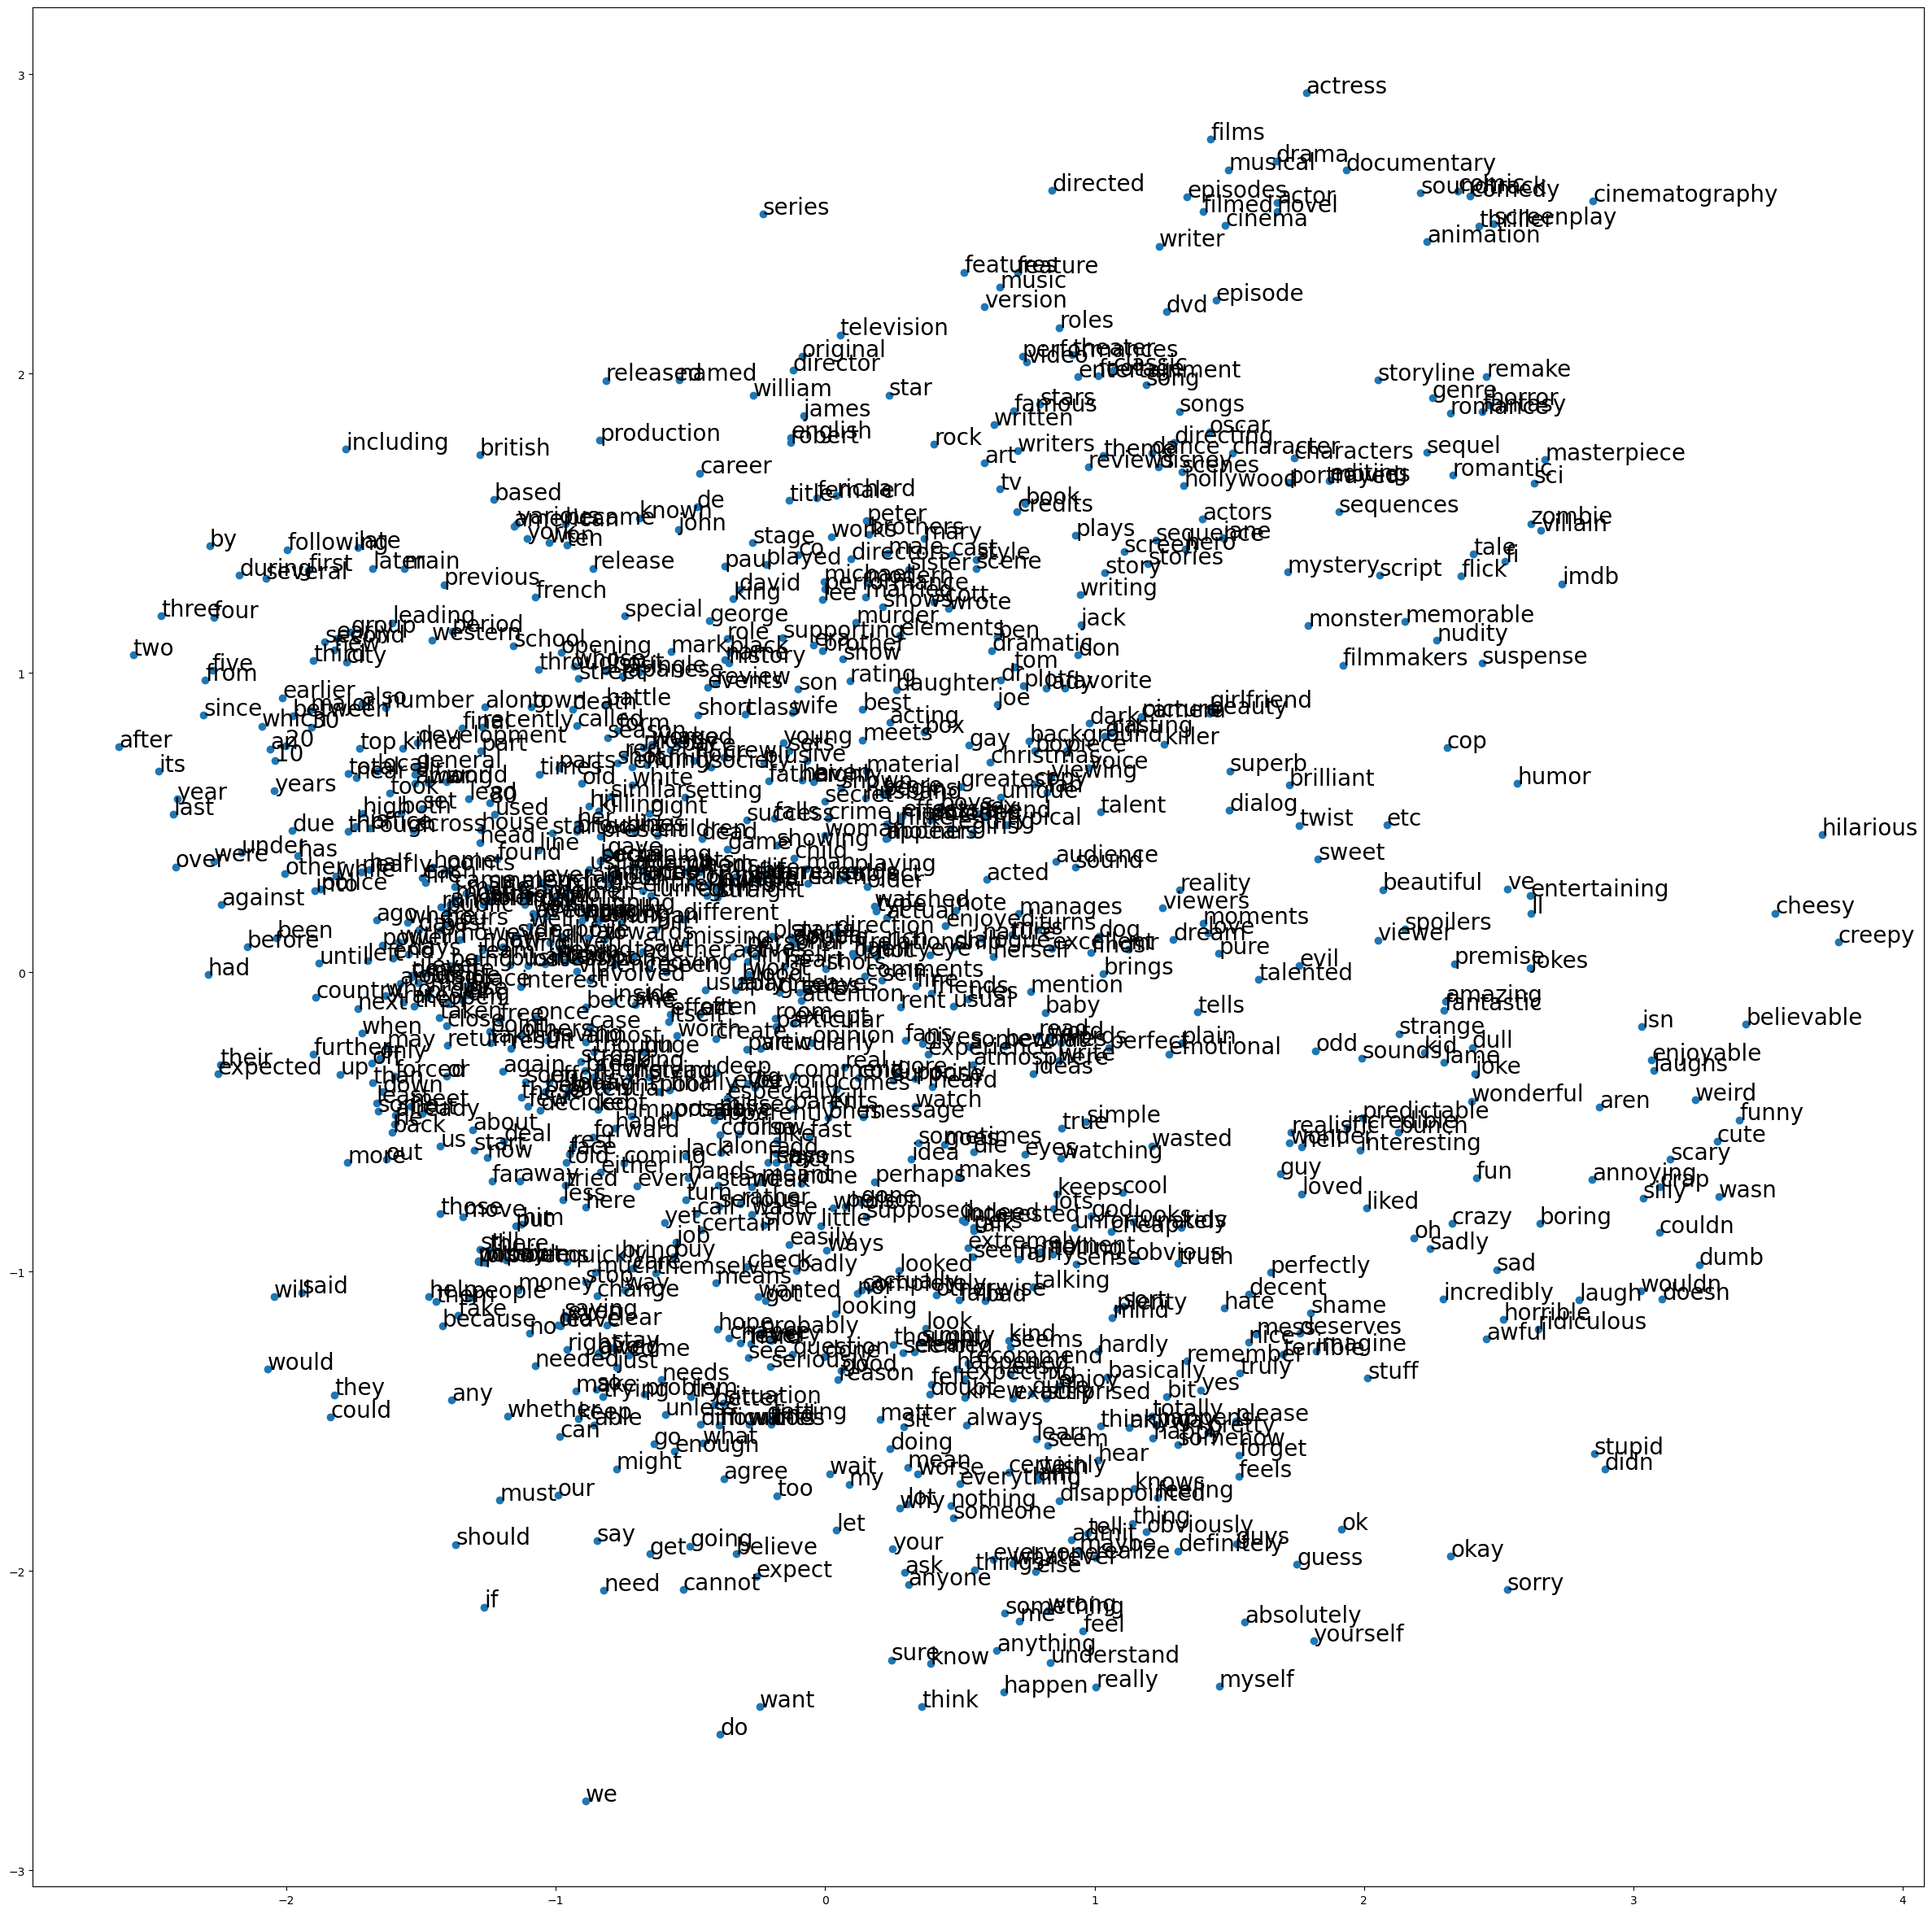

In [97]:
pca=PCA(n_components=2)
glove_pca=pca.fit_transform(dict_glove)

plt.figure(figsize=(30,30))
plt.scatter(glove_pca[:,0],glove_pca[:,1],)

for i in range(ld):
    plt.annotate(dictionary_small.get_feature_names_out()[i],(glove_pca[i,0],glove_pca[i,1]),fontsize=20)
plt.show()

**Tunning propositions**:
* Relevant descriptive adjectives with different sentiment meanings are clustered in close proximity. It would be more helpful if the positive adjectives were well separated from the negative adjectives.
* A higher $D$-dimensional space could provide more detail and seperate them from each other. 

**Conclusions**
* We see in our results that the performance varies significantly when determining the number of features. Although, we saw no improvements for the logistic regression model, a good classifier which generalizes well can lead to better results.

In [99]:
for max_features in [10, 50, 1000]:
    dictionary_small = CountVectorizer(min_df=50, max_df=0.5, max_features=max_features).fit(reviews_train.data)
    reviews_train_tf = dictionary_small.transform(reviews_train.data)
    reviews_test_tf = dictionary_small.transform(reviews_test.data)

    # Get the top 100 feature names
    top_words = dictionary_small.get_feature_names_out()
    
    # Construct a dictionary mapping each word to its GloVe vector
    ld = len(top_words)
    dict_glove = np.zeros((ld, 200))  # Assuming GloVe vectors are 100-dimensional
    for i, word in enumerate(top_words):
        if word in gl:
            dict_glove[i, :] = gl_2[word]

    # Calculate weighted GloVe representation
    reviews_train_glove = np.asarray(np.matmul(reviews_train_tf.todense(), dict_glove) / (reviews_train_tf.todense().sum(axis=1) + 0.00001))
    reviews_test_glove = np.asarray(np.matmul(reviews_test_tf.todense(), dict_glove) / (reviews_test_tf.todense().sum(axis=1) + 0.00001))
    print("glove feature matrix for training reviews has dimensions {}".format(reviews_train_glove.shape))
    print("glove feature matrix for testing reviews has dimensions {}".format(reviews_test_glove.shape))
    
    # Fit and evaluate MLP classifier
    mlp_model = MLPClassifier(max_iter=1000).fit(reviews_train_glove, reviews_train.target)
    predictions = mlp_model.predict(reviews_test_glove)
    print(f"MLP accuracy - num features {max_features}:", accuracy_score(reviews_test.target, predictions))
    
    # Train and evaluate logistic regression model
    lr_model = LogisticRegression(solver='lbfgs', max_iter=1000).fit(reviews_train_glove, reviews_train.target)
    predictions = lr_model.predict(reviews_test_glove)
    print(f"Logistic regression accuracy - num features {max_features}:", accuracy_score(reviews_test.target, predictions))

glove feature matrix for training reviews has dimensions (25000, 200)
glove feature matrix for testing reviews has dimensions (25000, 200)
MLP accuracy - num features 10: 0.57304
Logistic regression accuracy - num features 10: 0.57208
glove feature matrix for training reviews has dimensions (25000, 200)
glove feature matrix for testing reviews has dimensions (25000, 200)
MLP accuracy - num features 50: 0.67404
Logistic regression accuracy - num features 50: 0.68904
glove feature matrix for training reviews has dimensions (25000, 200)
glove feature matrix for testing reviews has dimensions (25000, 200)
MLP accuracy - num features 1000: 0.80676
Logistic regression accuracy - num features 1000: 0.81772
